In [12]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import numpy as np
import pandas as pd
import time
import datetime
import seaborn as sns
%matplotlib notebook

### Meteogram

In [2]:
import datetime
horas_sol = pd.read_excel('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/2020.xlsx', index_col=0, parse_dates=True)
horas_sol_2019 = pd.read_excel('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/2019_.xlsx', index_col=0, parse_dates=True)

#Agregar fecha, porque matplotlib lo requiere:
sunrise_time = []
k=0
for i in range(12):
    for c, t in enumerate(horas_sol.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2020, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunrise_time.append(tmp)  
    k += 2

sunset_time = []
k=1
for i in range(12):
    for c, t in enumerate(horas_sol.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2020, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunset_time.append(tmp)  
    k += 2

#Corregir horario de invierno, dejar todo en horario de verano: UTC-3:
sunrise_time[96:250] = [sunrise_time[d] + datetime.timedelta(hours=1) for d in np.arange(96,250)]
sunset_time[96:250] = [sunset_time[d] + datetime.timedelta(hours=1) for d in np.arange(96,250)]

#Agregar fecha, porque matplotlib lo requiere:

sunrise_time_2019 = []
k=0
for i in range(12):
    for c, t in enumerate(horas_sol_2019.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2019, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunrise_time_2019.append(tmp)  
    k += 2

sunset_time_2019 = []
k=1
for i in range(12):
    for c, t in enumerate(horas_sol_2019.iloc[:,k]):
        if type(t) == datetime.time:
            my_day = datetime.date(2019, i+1, c+1)
            tmp = datetime.datetime.combine(my_day, t)
            sunset_time_2019.append(tmp)  
    k += 2
    
#Corregir horario de invierno, dejar todo en horario de verano: UTC-3:
sunrise_time_2019[97:251] = [sunrise_time_2019[d] + datetime.timedelta(hours=1) for d in np.arange(97,251)]
sunset_time_2019[97:251] = [sunset_time_2019[d] + datetime.timedelta(hours=1) for d in np.arange(97,251)]

sunrise = [*sunrise_time_2019, *sunrise_time]
sunset = [*sunset_time_2019, *sunset_time]
sunrise = pd.to_datetime(sunrise)
sunset = pd.to_datetime(sunset)

from datetime import datetime

sunrise.to_pydatetime()
times = []
for date in sunrise:
    current_time = date.strftime("%H:%M")
    t = datetime.strptime(current_time, '%H:%M').time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    times.append(seconds/86400)

sunset.to_pydatetime()
times2 = []
for date in sunset:
    current_time = date.strftime("%H:%M")
    t = datetime.strptime(current_time, '%H:%M').time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    times2.append(seconds/86400)

temperatura = pd.read_csv('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/days_2019_2020.csv')
temperatura_w = pd.read_csv('../DATOS_METEOROLOGICOS/HORAS_LUZ_SOL_temp/weeks_t.csv')

In [3]:
temperatura = temperatura[291:697]

### Read C5, presences & probabilities

In [259]:
path = '../binarios/'
sites = [s for s in sorted(os.listdir(path)) if not s.startswith('.')]
sites

['Angachilla', 'Miraflores', 'PUEBosque']

In [269]:
C5_mixed = np.zeros([10,24,406])# (10 species, 24 hrs, 406 days)
for site in sites:
    C5_filenames = []
    for f in sorted(os.listdir(path+site+'/')):
        if f.endswith('C5_fixed.pkl'):
            C5_filenames.append(f)
    # read binary:
    for n, c in enumerate(C5_filenames):
        data_store = open(path+site+'/'+c, 'rb') 
        C5_temp = pickle.load(data_store)
        C5_mixed[n,:,:] = C5_temp + C5_mixed[n,:,:]
        data_store.close()

In [265]:
#sns.heatmap(C5_mixed[3])

### Plot

In [266]:
#Create color map:
#https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/
hsv_modified = cm.get_cmap('winter', 256)# create new hsv colormaps in range of 0.3 (green) to 0.7 (blue)
newcmp = ListedColormap(hsv_modified(np.linspace(0.3, 0.9, 256)))# from blue to purple

In [270]:
specie = 8

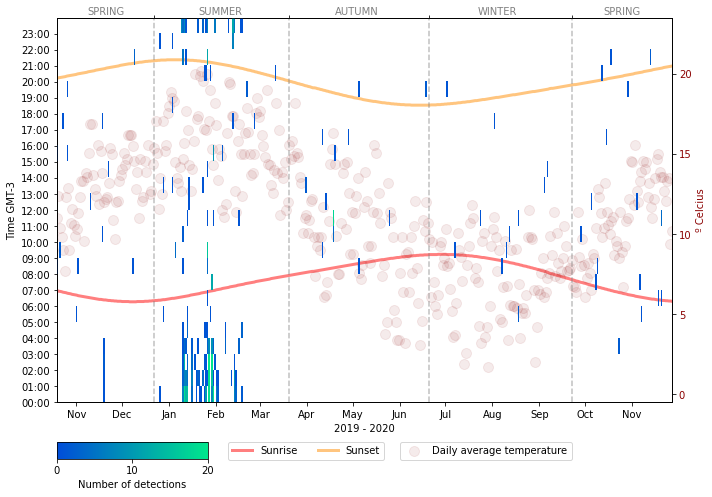

In [271]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(10,7), facecolor='w')

# Data

date_list = sunrise[291:697]
y = times[291:697]
date_list2 = sunset[291:697]
y2 = times2[291:697]

###### Set the locator #####
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
xfmt = mdates.DateFormatter('%b')
yfmt = mdates.DateFormatter('%H:%M')
############################
###### sunlight ############
ax1.plot(date_list, y, label='Sunrise', c='red', zorder=3, alpha=0.5, linewidth=3)
ax1.plot(date_list2, y2, label='Sunset', c='darkorange', zorder=4, alpha=0.5, linewidth=3)
ax1.set_xlabel('2019 - 2020')
ax1.set_ylabel('Time GMT-3')
ax1.set_yticks(np.arange(24)/24)
ax1.set_ylim(0, 1)
ax1.set_xlim(date_list[0], date_list[-1])
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(xfmt)
Y = plt.gca().yaxis
Y.set_major_formatter(yfmt)
############################
###### temperature #########
ax2 = ax1.twinx()
ax2.scatter(date_list, temperatura.iloc[:,1], s=100, alpha=0.08, label='Daily average temperature', 
            c='darkred', zorder=2, vmin=10, vmax=15)
ax2.set_ylabel('º Celcius', c='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
#ax2.set_xlim(0, 1)

###########################
##### heatmap #############

ax3 = ax2.twiny()

data = C5_mixed[specie]
masked_data = np.ma.masked_where(data<1, data)
vmin, vmax = (0, 20)

im = ax3.imshow(masked_data, vmin=vmin, vmax=vmax, cmap=newcmp, aspect='auto', 
                zorder=1, interpolation='none',alpha=1)
ax3.invert_yaxis()
ax3.set_xlim(0,405)
ax3.set_xticks(ticks=[64, 153, 245, 339], labels='')
ax3.axvline(64, linestyle='--', color='grey', alpha=0.5)
ax3.axvline(153, linestyle='--', color='grey', alpha=0.5)
ax3.axvline(245, linestyle='--', color='grey', alpha=0.5)
ax3.axvline(339, linestyle='--', color='grey', alpha=0.5)
ax3.text(20,23.7,'SPRING', color='grey')
ax3.text(93,23.7,'SUMMER', color='grey')
ax3.text(183,23.7,'AUTUMN', color='grey')
ax3.text(277,23.7,'WINTER', color='grey')
ax3.text(360,23.7,'SPRING', color='grey')

cbar = fig.colorbar(im, ticks=[vmin, ((vmax-vmin)/2)+vmin, vmax], label = 'Number of detections',
                   fraction=0.038, pad=0.09, orientation='horizontal', aspect=9, anchor=(0, -0.5))
#cbar.ax3.yticklabels([str(vmin), str(vmax/2), str(vmax)+'+'])

#ax3.axis('off')

###########################


ax1.legend(fontsize=10, ncol=2, bbox_to_anchor=(0.54, -0.09))
ax2.legend(fontsize=10, bbox_to_anchor=(0.845, -0.09))


plt.tight_layout()
plt.savefig('POSP_kiker_3sites_0.17.png', format='png', dpi=300)
#plt.savefig('only_meteogram.png', format='png', dpi=300)
plt.show()